Initial setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import wosis
import pandas as pd
import metaknowledge as mk

# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\fuzzywuzzy-0.17.0-py3.6.egg\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
RC = mk.RecordCollection("tmp/rest_requested_corpora.txt")
corpora_df = wosis.rc_to_df(RC)

In [4]:
wos_config = wosis.load_config('config.yml')

<hr> Analysing software packages in the corpora <br>


In [16]:
uc_software_packages = wosis.keyword_matches(RC, ['software', 'toolkit', 'toolbox'], threshold=95.0)

In [26]:
all_uc_software = uc_software_packages.combine_recs()

In [28]:
(wosis.rc_to_df(all_uc_software)).to_csv('../data/software_packages_rest.csv')

    - Keyword trend 
    - Key-phrase analysis

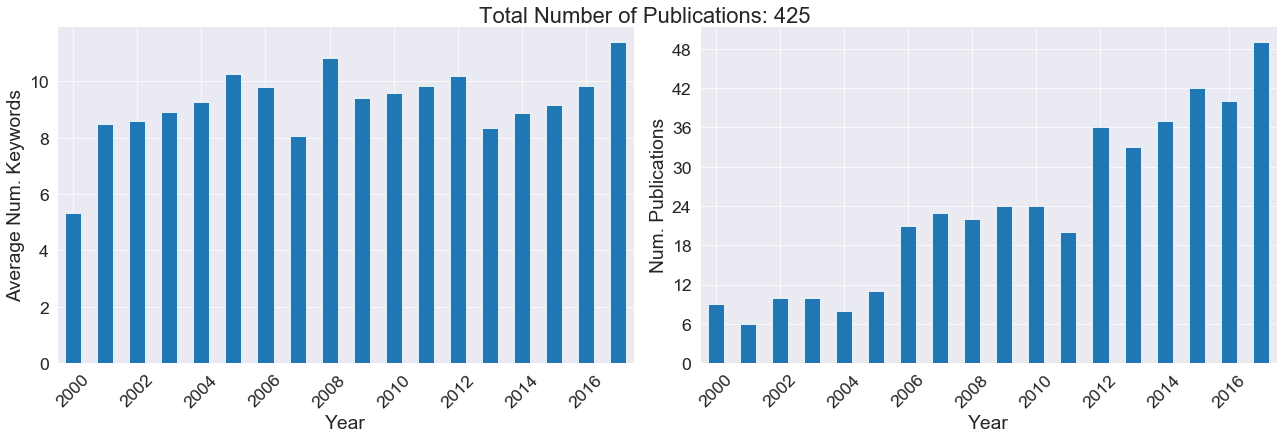

In [13]:
wos_plot.plot_kw_trend(all_uc_software)

In [38]:
software_phrases = wosis.analysis.constrain.find_phrases(wosis.rc_to_df(all_uc_software))

In [39]:
software_phrases.display_phrases()

Risk assessment of pesticides and other stressors in bees: Principles, data gaps and perspectives from the European Food Safety Authority (2017) 
https://dx.doi.org/10.1016/j.scitotenv.2016.09.127 

(C)  The Authors. 

Finally, the evidence collected within the framework of MUST-B will support EFSA's activities on the development of a holistic approach to the risk assessment of multiple stressors in bees. 

The EFSA Guidance Document on the risk assessment of plant protection products in bees highlights the need for the inclusion of an uncertainty analysis, other routes of exposures and multiple stressors such as chemical mixtures and biological agents. 

The European Food Safety Authority (EFSA) is deploying resources and efforts to move towards a holistic risk assessment approach of multiple stressors in bees. 

Finally, the recent work conducted at EFSA is presented, under the over-arching MUST-B project ("EU efforts towards the development of a holistic approach for the risk assess

NHPP software reliability model considering the uncertainty of operating environments with imperfect debugging and testing coverage (2017) 
https://dx.doi.org/10.1016/j.apm.2017.06.034 

Many NHPP software reliability growth models (SRGMs) have been developed to estimate the software reliability measures, but most of the underlying common assumptions of these models are that the operating environment is the same as the developing environment. 

Improved normalized criteria distance (NCD) method is also used to rank and select the best model in the context of a set of goodness-of-fit criteria taken all together. 

In this paper, a new model is proposed with the consideration of the fault detection rate based on the testing coverage and examined to cover ID subject to the uncertainty of operating environments. 

But in fact, due to the unpredictability of the uncertainty in the operating environments for the software, environments may considerably influence the reliability and software's

The calibrated model rendered coefficients of determination (R()) of ., . 

A six-year simulation of N(am) showed stable behaviour over time. 

for N(am), N(ox) and N(org) respectively. 

Performance measures quantitatively expressing the deviation between modelled and measured data resulted in values close to zero, indicating a stable model structure. 


Numerical simulation of 3D bubbles rising in viscous liquids using a front tracking method (2008) 
https://dx.doi.org/10.1016/j.jcp.2007.12.002 

In addition, we applied this model to simulate the interaction between two bubbles rising in a liquid, which illustrated the model's capability in predicting the interaction dynamics of rising bubbles. 

The numerical model is integrated with the software package PARAMESH, a block-based adaptive mesh refinement (AMR) tool developed for parallel computing. 

Simulation results are compared with experimental observations both in aspect of terminal bubble shapes and terminal bubble velocities. 

The aim of this paper is to determine the alternatives and the sensitivity of main factors affecting water and energy consumption as well as environmental impact in a recycled paper manufacturing by using analytic hierarchy process (AHP). 

Multi-criteria decision making (MCDM) was used to make comparative analysis of projects or heterogeneous measures for prioritization criteria and subcriteria simultaneously in a complex situation. 

Also, good housekeeping is the most sensitive criterion affecting the alternatives. 


Direct effect of atmospheric turbulence on plume rise in a neutral atmosphere (2017) 
https://dx.doi.org/10.1016/j.apr.2017.01.001 

The direct effect of atmospheric turbulence on plume rise in the current research work is studied through examining the turbulence intensity parameter. 

Furthermore, the buoyancy parameter of the flue gas is determined at some distances upstream of the stack top surface to include the whole effects of source buoyancy on the plume rise. 


Three design cases are based on typical biogas applications: () biogas upgrading using a monoethanolamine (MEA) unit to remove CO, () combustion of raw biogas in a combined heat and power (CHP) plant and () combustion of upgraded biogas in a CHP plant which represents a combination of the first two options. 

pound per litre of liquid fuels, respectively. 

The studied CCU options are compared in terms of liquid fuel yields, energy requirements, energy efficiencies, capital investment and production costs. 

The overall plant energy efficiency and production costs range from -% and .-. 


Inverse heat transfer analysis of radiator central heating systems inside residential buildings using sensitivity analysis (2017) 
https://dx.doi.org/10.1080/17415977.2016.1178258 

With the use of numerical simulation, thermal analysis of building components is simulated in order to calculate temperature field in the computational domain. 

The present study illustrates the sufficiency of inverse ana

In addition, the effectiveness of PINN for estimating labor production rates in the context of the application domain was validated through sensitivity analysis. 

This paper discusses the derivation of a probabilistic neural network classification model and its application in the construction industry. 

The topology and algorithm of the developed model was presented and explained in detail. 


Analyzing Complex Treatment Effects in Nonrandomized Observational Studies: The Case of Retention of Students in Grade (2016) 
https://dx.doi.org/10.1080/00273171.2016.1251756 

Should low-achieving students be promoted to the next grade or be retained (held back) in the prior grade? 


Process simulation and techno economic analysis of renewable diesel production via catalytic decarboxylation of rubber seed oil - A case study in Malaysia (2017) 
https://dx.doi.org/10.1016/j.jenvman.2017.05.053 

With the forecasted renewable diesel retail price of . 

Sensitivity analysis conducted showed that

In: Memoirs of the th International Congress on the Hydrogeology of Rocks of Low Permeability, U.S.A. Members of the International Association of Hydrologists, Tucson, AZ, vol. 


Sensitivity testing of a model for exploring water resources utilisation and management options (2005) 
https://dx.doi.org/10.1016/j.envsoft.2004.09.011 

The toolbox was developed for application in the highland regions of northern Thailand. 

There is potential for the model to be further simplified although more extensive model testing is required to ensure that such simplifications would not adversely impact on the utility of the toolbox. 

The hydrologic component showed strong non-linearity to the infiltration parameters of the CATCHCROP model, although this did not greatly impact estimates of total annual discharge. 

This paper explores sensitivities in the Biophysical Toolbox to the parameters of CATCHCROP as this component has the greatest potential for propagating errors though the Toolbox. 

In de

It also shows the importance of groundwater flow (flux > (-) m/s) on thermal recovery of the ground over other factors. 

Sensitivity of the loop outlet temperatures and heat exchange rates to hydrogeological, system and meteorological factors (i.e. 


Sensitivity of Flood-Depth Frequency to Watershed-Runoff Change and Sea-Level Rise Using a One-Dimensional Hydraulic Model (2016) 
https://dx.doi.org/10.1061/(ASCE)HE.1943-5584.0001378 

The results indicate that the effects of the upstream and downstream changes are not additive. 

A current-climate flood-depth frequency curve was estimated for the study site based on simulations of high-flow events in the years for which simultaneous upstream and downstream records were available. 

The method was applied to an ungauged location on a tidal estuary in the Mid-Atlantic region as a case study. 

For this location, the % annual exceedance (-year) WSEL is .m (.ft) higher, and the .% annual exceedance (-year) WSEL is m (.ft) higher, than cur

In genome-wide association studies, where hundreds of thousands of single nucleotide polymorphisms (SNPs) are genotyped, the potential for false positives is high and methods for selecting models with only a few SNPs are required. 


SEVIRI PrePro: A novel software tool for the pre-processing of SEVIRI geostationary orbit EO data products (2016) 
https://dx.doi.org/10.1016/j.envsoft.2016.03.015 

From the sensor a series of operational products are also provided to the user's community at no cost via EUMETSAT or LSA SAF portals. 

Its use is anticipated to make a significant contribution to a large number of practical applications requiring use of SEVIRI data, including but not limited, weather forecasting and global climate monitoring at a range of geographical scales. 

Herein, an open access stand-alone software product developed in Java programming language is presented for automating key pre-processing steps to all the SEVIRI operationally distributed products. 

The development o

The Influence of Model Structure Uncertainty on Water Quality Assessment (2016) 
https://dx.doi.org/10.1007/s11269-016-1330-x 

This paper aims to improve the insight in the uncertainties related to state-of-the-art river physico-biochemical water quality modelling. 

Each model relies on specific sets of assumptions and equations to simulate the physico-biochemical processes, which influence on its simulation results. 

Firstly, the physico-biochemical processes are screened to obtain a preliminary assessment on the critical processes and to determine the processes that require more detailed comparison. 

This is done for the Molse Neet river case study. 

Physically-based mathematical water quality models are known as potentially effective tools to simulate the temporal and spatial variations of water quality variables along rivers. 


Matrix-free algorithm for the optimization of multidisciplinary systems (2017) 
https://dx.doi.org/10.1007/s00158-017-1734-0 

The Krylov method also 

<hr>
Create a dataframe of relevant papers: manual sorting